In [1]:
from sympy import Symbol, integrate, sqrt
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dataclasses import dataclass

In [2]:
@dataclass
class Param:
    name: str
    range: tuple = None
    values: list = None
    dtype: type = float        

        
def get_initial_table(
    *params,
    **kwargs
):
    param_names = []
    param_values = []
    
    fixed_values = kwargs
    
    for param in params:
        param_names.append(param.name)
        if param.range is not None:
            values = np.arange(*param.range)
        else:
            values = param.values
        param_values.append(values)
    multiidx = pd.MultiIndex.from_product(
        param_values,
        names=param_names
    )
    return pd.DataFrame(
        fixed_values,
        index=multiidx
    ).reset_index()
  
# This function calculates c=pT/Q  
def fill_in_related_values(
    df
):
    updates = {}
    if 'c' in df:
        assert 'Q' not in df
        assert 'pT' not in df
        return df
    if 'Q' in df and 'c' in df:
        updates['pT'] = df['c'] * df['Q']
    elif 'Q' in df and 'pT' in df:
        updates['c'] = df['pT'] / df['Q']
    else:
        raise ValueError(
            f'column combination not supported! {df.columns}'
        )
    return (
        df
        .assign(**updates)
    )   


def get_observables(
        z,
        c, # c=pT/Q
        xi: Symbol,
        phi,
        y=0.4, # As taken in the paper
        N=1, # N cancels out in the formulas below
        xB=1, # xB cancels out in the formulas below
    ):

    func_1 = phi/(z-xi*(z**2 - c**2))
    func_2 = phi/(1 - xi)

    # Calculate integrals
    I1 = z*integrate(func_1, (xi, 0, 1)) # Eq. (13)
    I2 = integrate(func_2, (xi, 0, 1)) - z**2*I1

    # Calculate values of structure functions 
    H1 = N* 1/(2*xB)*(I2*I2 + c**4*I1*I1)
    H11 = N* 1/(2*xB)*(I2*I2)
    H2 = N*(I2*I2 + 4*c**2*z*z*I1*I1 + c**4*I1*I1)
    H22 = N*(I2*I2)
    H3 = N*2*z*I1*(I2-c**2*I1)
    H4 = -N*2*I1*I2

     # Calculate asymmetries and R 
    cos_denominator = xB * y**2 * H1 + (1-y) * H2
    cos_theta = 0.5 * c * ((2-y)*sqrt(1-y)*H3)/(cos_denominator) #Eq. (7)
    cos_2theta = 0.5 * c**2 * ((1-y)*H4)/(cos_denominator) #Eq. (8)
    R = (H2 - 2*xB*H1)/H2 #Eq. (9)
    cs_HT = (xB*y**2*H1+(1-y)*H2)
    cs_LT = (xB*y**2*H11+(1-y)*H22)
    Rat = cs_LT/cs_HT

    observables = dict(
        I1=I1,
        I2=I2,
        H1=H1,
        H2=H2,
        H3=H3,
        H4=H4,
        cos_theta=cos_theta,
        cos_2theta=cos_2theta,
        cos_denominator=cos_denominator,
        R=R,
        cs_HT=cs_HT,
        cd_LT=cs_LT,
        Rat=Rat
    )
    return observables


def calculate_integrals(
        df,
        **kwargs
    ):
    xi = Symbol('xi')
    phi = 30*(1-xi)*xi*(1-4*(1-xi)*xi) # distribution amplitude
    
    def func_to_apply_to_each_row(row, **kw):
        observables_for_row = get_observables(
            row.z,
            row.c,
            **kw
        )
        return pd.Series(observables_for_row).astype(float)
    
    df_observables = (
        df
        .apply(
            func_to_apply_to_each_row,
            axis='columns',
            xi=xi,
            phi=phi,
            **kwargs
        )
    )

    return (
        # create a dataframe with all columns from df and df_observables
        pd.concat(
            [df, df_observables],
            axis='columns'
        )
    )

def get_table(
        *args, **kwargs
    ):
    return (
        get_initial_table(
            *args, **kwargs
        )
        .pipe(fill_in_related_values)
        .pipe(calculate_integrals)
    )

c    y  N        I1        I2         H1         H2        H3  \
z                                                                       
0.50  0.5  0.5  1  1.000000  4.750000  11.312500  22.875000  4.500000   
0.51  0.5  0.5  1  1.010047  4.737287  11.252824  22.771001  4.620430   
0.52  0.5  0.5  1  1.020183  4.724143  11.191286  22.663996  4.741668   
0.53  0.5  0.5  1  1.030424  4.710554  11.127839  22.553930  4.863732   
0.54  0.5  0.5  1  1.040778  4.696509  11.062450  22.440767  4.986595   
0.55  0.5  0.5  1  1.051251  4.681996  10.995081  22.324463  5.110240   
0.56  0.5  0.5  1  1.061855  4.667002  10.925691  22.204977  5.234650   
0.57  0.5  0.5  1  1.072597  4.651513  10.854240  22.082266  5.359803   
0.58  0.5  0.5  1  1.083487  4.635515  10.780686  21.956286  5.485679   
0.59  0.5  0.5  1  1.094535  4.618993  10.704984  21.826993  5.612252   
0.60  0.5  0.5  1  1.105750  4.601930  10.627089  21.694343  5.739496   
0.61  0.5  0.5  1  1.117143  4.584311  10.546954  21.558292  5.867382   
0.62  0.5  0.5  1  1.128725  4.566118  10.464531  21.418794  5.995879   
0.63  0.5  0.5  1  1.140506  4.547333  10.379768  21.275805  6.124951   
0.64  0.5  0.5  1  1.152498  4.527937  10.292614  21.129280  6.254560   
0.65  0.5  0.5  1  1.164712  4.507909  10.203014  20.979173  6.384662   
0.66  0.5  0.5  1  1.177162  4.487228  10.110912  20.825440  6.515212   
0.67  0.5  0.5  1  1.189859  4.465872  10.016250  20.668036  6.646157   
0.68  0.5  0.5  1  1.202818  4.443817   9.918965  20.506918  6.777440   
0.69  0.5  0.5  1  1.216053  4.421037   9.818996  20.342042  6.908998   
0.70  0.5  0.5  1  1.229579  4.397506   9.716277  20.173367  7.040761   
0.71  0.5  0.5  1  1.243411  4.373196   9.610738  20.000850  7.172653   
0.72  0.5  0.5  1  1.257567  4.348077   9.502309  19.824454  7.304587   
0.73  0.5  0.5  1  1.272064  4.322117   9.390915  19.644141  7.436470   
0.74  0.5  0.5  1  1.286921  4.295282   9.276480  19.459876  7.568196   
0.75  0.5  0.5  1  1.302157  4.267537   9.158923  19.271628  7.699649   
0.76  0.5  0.5  1  1.317794  4.238842   9.038159  19.079368  7.830699   
0.77  0.5  0.5  1  1.333855  4.209158   8.914102  18.883074  7.961204   
0.78  0.5  0.5  1  1.350363  4.178439   8.786661  18.682727  8.091002   
0.79  0.5  0.5  1  1.367345  4.146640   8.655739  18.478314  8.219916   
0.80  0.5  0.5  1  1.384827  4.113711   8.521237  18.269832  8.347746   
0.81  0.5  0.5  1  1.402840  4.079597   8.383053  18.057285  8.474271   
0.82  0.5  0.5  1  1.421416  4.044240   8.241077  17.840687  8.599242   
0.83  0.5  0.5  1  1.440588  4.007579   8.095198  17.620065  8.722381   
0.84  0.5  0.5  1  1.460394  3.969546   7.945296  17.395461  8.843375   
0.85  0.5  0.5  1  1.480874  3.930068   7.791249  17.166933  8.961873   
0.86  0.5  0.5  1  1.502072  3.889068   7.632930  16.934561  9.077480   
0.87  0.5  0.5  1  1.524035  3.846458   7.470204  16.698446  9.189749   
0.88  0.5  0.5  1  1.546813  3.802148   7.302933  16.458721  9.298177   
0.89  0.5  0.5  1  1.570465  3.756035   7.130973  16.215549  9.402192   
0.90  0.5  0.5  1  1.595050  3.708010   6.954173  15.969135  9.501146   
0.91  0.5  0.5  1  1.620637  3.657951   6.772378  15.719731  9.594300   
0.92  0.5  0.5  1  1.647300  3.605726   6.585429  15.467645  9.680813   
0.93  0.5  0.5  1  1.675120  3.551189   6.393159  15.213250  9.759719   
0.94  0.5  0.5  1  1.704189  3.494178   6.195400  14.957004  9.829911   
0.95  0.5  0.5  1  1.734608  3.434517   5.991979  14.699458  9.890113   
0.96  0.5  0.5  1  1.766488  3.372005   5.782723  14.441280  9.938853   
0.97  0.5  0.5  1  1.799956  3.306422   5.567457  14.183280  9.974418   
0.98  0.5  0.5  1  1.835152  3.237520   5.346011  13.926441  9.994816   
0.99  0.5  0.5  1  1.872237  3.165021   5.118219  13.671952  9.997714   
1.00  0.5  0.5  1  1.911390  3.088610   4.883926  13.421263  9.980370   

             H4  cos_theta  cos_2theta  cos_denominator         R      cs_HT  \
z                                                         

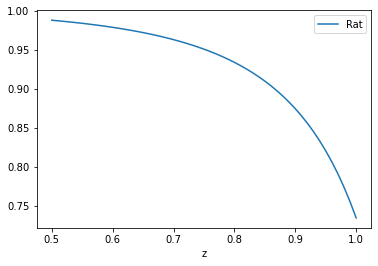

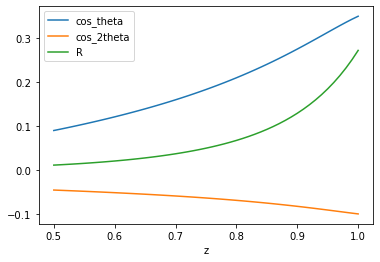

In [3]:
# scan functions of z for set c
df = get_table(
    Param(name='c', values=[0.5]),
    Param(name='z', range=(0.5, 1.01, 0.01)), #range=(up, down, step)
    y=0.5,
    N=1,
).set_index('z') # ploted as a function of z
df[['Rat']].plot()
plt.savefig('R_vs_z_c_0.5.png', dpi=300)
df[['cos_theta', 'cos_2theta', 'R']].plot()
df

<AxesSubplot:xlabel='Q'>

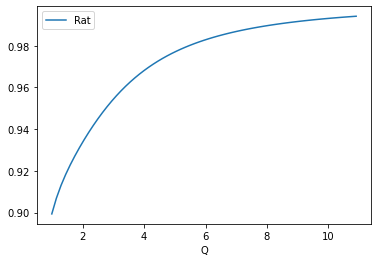

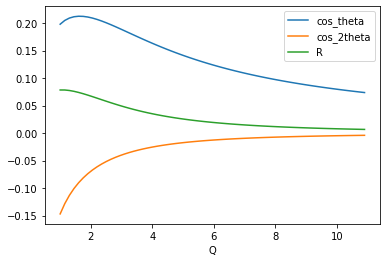

In [4]:
# scan functions of Q for set pT
df = get_table(
    Param(name='z', values=[0.8]),
    Param(name='Q', range=(1., 11., 0.15)),
    Param(name='pT', values=[1.0]),
    y=0.5,
    N=1,
).set_index('Q')
df[['Rat']].plot()
plt.savefig('R_vs_Q_z_0.8_pT_1.0.png', dpi=300)
df[['cos_theta', 'cos_2theta', 'R']].plot()

<AxesSubplot:xlabel='c'>

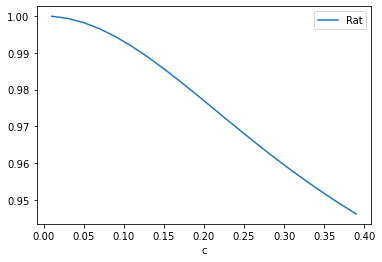

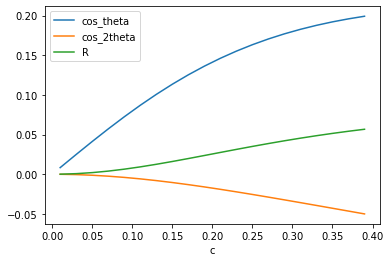

In [5]:
# scan functions of c
df = get_table(
    Param(name='z', values=[0.8]),
    Param(name='c', range=(0.01, 0.4, 0.02)),
    y=0.5,
    N=1,
).set_index('c')
df[['Rat']].plot()
plt.savefig('R_vs_c_z_0.8.png', dpi=300)
df[['cos_theta', 'cos_2theta', 'R']].plot()

<AxesSubplot:xlabel='pT'>

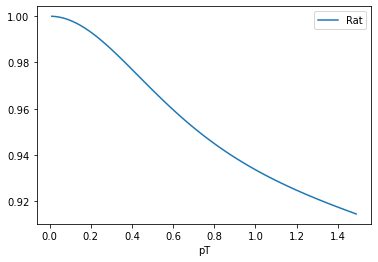

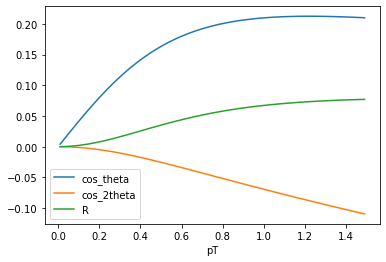

In [6]:
df = get_table(
    Param(name='z', values=[0.8]),
    Param(name='Q', values=[2]),
    Param(name='pT', range=(0.01, 1.5, 0.02)),
    y=0.5,
    N=1,
).set_index('pT')
df[['Rat']].plot()
plt.savefig('R_vs_pT_z_0.8_Q_2.png', dpi=300)
df[['cos_theta', 'cos_2theta', 'R']].plot()

<AxesSubplot:xlabel='z'>

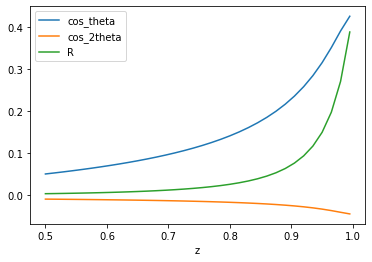

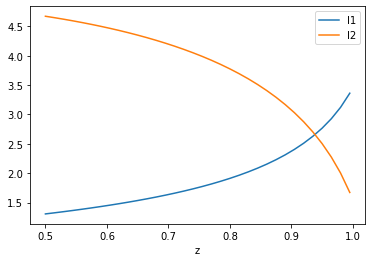

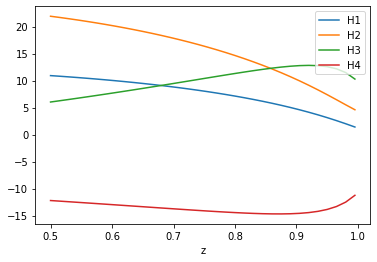

In [7]:
df = get_table(
    Param(name='c', values=[0.2]),
    Param(name='z', range=(0.5, 1.01, 0.015)),
    y=0.4,
    N=1,
).set_index('z')

df[['cos_theta', 'cos_2theta', 'R']].plot()
df[['I1', 'I2']].plot()
df[['H1', 'H2', 'H3', 'H4']].plot()